In [6]:
import numpy as np 
import pandas as pd 
import os 
import h5py 
import csv 
import datetime as dt
import matplotlib.pyplot as plt
from sklearn import utils

In [4]:
file_loc = 'cleaned.hdf5'
dset = 'utexas'
def get_psus():
    unique_psu = {}
    with h5py.File(file_loc,'r') as f:
        d = f[dset]
        for b in d.keys():
            if 'PSU' in d[b].attrs:
                if d[b].attrs['PSU'] not in unique_psu:
                    unique_psu[d[b].attrs['PSU']] = 1
                else:
                    unique_psu[d[b].attrs['PSU']] = unique_psu[d[b].attrs['PSU']]+1
    return unique_psu
def get_building(build,year):
    with h5py.File(file_loc,'r') as f:
        d = f[dset]
        df = pd.DataFrame(d['{}/{}'.format(build,year)][()])
    return df

<h2><font color = #bf5700>Metadata analysis</font></h2>

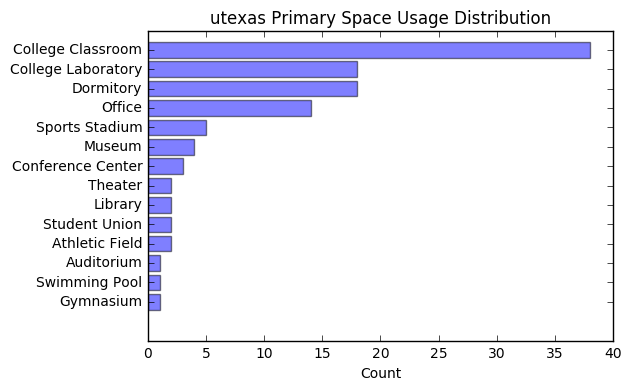

In [24]:
data = get_psus()
uniques = data.keys()
values = [data[psu] for psu in uniques]
df = pd.DataFrame()
df.loc[:,'PSU'] = uniques
df.loc[:,'Count'] = values
df.sort_values(by='Count',ascending=True,inplace=True)
plt.barh(np.arange(len(uniques)), df.loc[:,'Count'], align='center', alpha=0.5)
plt.yticks(np.arange(len(uniques)), df.loc[:,'PSU'])
plt.xlabel('Count')
plt.title('utexas Primary Space Usage Distribution')
plt.show()

<h2><font color=#bf5700>Daily Profile</font></h2>

In [9]:
def byte_to_obj(build_df):
    df = build_df.copy()
    #Byte to String (decode utf8) to Datetime (parsetime with format YYYY-mm-dd HH:MM:SS)
    df.loc[:,0] = df.apply(lambda x:dt.datetime.strptime(x[0].decode('utf8'),'%Y-%m-%d %H:%M:%S'),axis=1 )
    #Byte to String (decode utf8) to float
    df.loc[:,1] = df.apply(lambda x: float(x[1].decode('utf8')),axis=1)
    return df
#Clean zero values
def clean_zero(build_df):
    df = build_df.copy()
    #Return times and data where usage is positive.
    #Filters zero and negative numbers
    return df[df[1]>0]

def daily_profile(building, year):
    with h5py.File(file_loc,'r') as f:
        df = pd.DataFrame(f['{}/{}/{}'.format(dset,building,year)][()])
        df = clean_zero(byte_to_obj(df))
        data = []
        for h in range(24):
            hour_data = df[df.apply(lambda x: x[0].hour==h,axis=1)].loc[:,1]
            data.append(hour_data)
    return data

daily_profile() produces the hourly energy consumption of a typical day

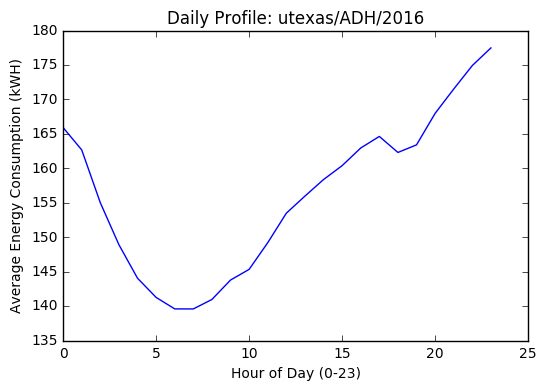

In [45]:
prof = daily_profile('ADH',2016)
hour_avs = [sum(d)/len(d) for d in prof]
plt.plot(np.arange(24),hour_avs)
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Average Energy Consumption (kWH)')
plt.title('Daily Profile: utexas/ADH/2016')
plt.show()

We can see that the shape of the daily profile is largely resistant to changes in year: 

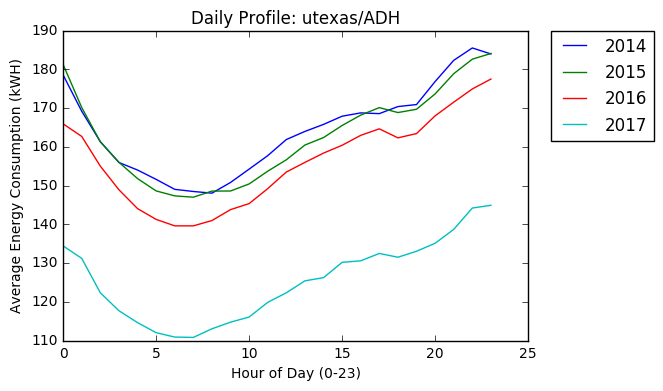

In [46]:
for i in range(2014,2018):
    prof = daily_profile('ADH',i)
    hour_avs = [sum(d)/len(d) for d in prof]
    plt.plot(np.arange(24),hour_avs,label=i)
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Average Energy Consumption (kWH)')
plt.title('Daily Profile: utexas/ADH')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

2017 data might be unusually low due to the fact that data collection stopped in Jul 31, 2017. Since ADH is a dormitory, it experiences lower power demand in the summer months. A standard dormitory might have 7-8 months of high-usage, and 4-5 months of low-usage, whereas 2017 data, by virtue of being incomplete (data collection stopped after July), is only 4 months of high usage and 3 months of low-usage. As such, the mean might be pulled down

<h2> <font color = #bf5700> Profile Comparison </font> </h2>

We can see that buildings with the same primary space usage tend to have the same daily profile shape. Shown below are the daily profiles of two dormitory buildings (ADH, SJH)

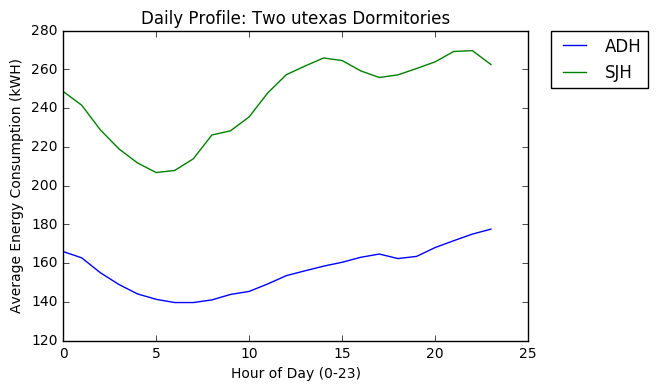

In [47]:
ADH_avs = [sum(d)/len(d) for d in daily_profile('ADH',2016)]
plt.plot(np.arange(24),ADH_avs,label='ADH')
SJH_avs = [sum(d)/len(d) for d in daily_profile('SJH',2016)]
plt.plot(np.arange(24),SJH_avs,label='SJH')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Average Energy Consumption (kWH)')
plt.title('Daily Profile: Two utexas Dormitories')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

and also the daily profiles of two laboratory buildings (WEL,NHB)

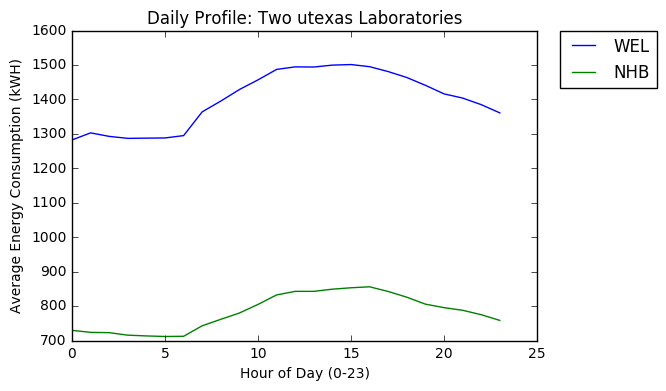

In [48]:
WEL_avs = [sum(d)/len(d) for d in daily_profile('WEL',2016)]
plt.plot(np.arange(24),WEL_avs,label='WEL')
NHB_avs = [sum(d)/len(d) for d in daily_profile('NHB',2016)]
plt.plot(np.arange(24),NHB_avs,label='NHB')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Average Energy Consumption (kWH)')
plt.title('Daily Profile: Two utexas Laboratories')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

To compare the exact shape we need normalization techniques

<h2><font color=#bf5700>Normalization techniques</font></h2>
<h3><font color=#333f48>Z-score normalization </font></h3>

We can start by normalizing data as z standard deviations above the average of the data. 

In [65]:
def z_normalize(avs,nested_data=False):
    #If data is direct output from profile, it is in form [[a1,a2,a3,a4,...],[b1,b2,b3,b4,...],...]
    if(nested_data):
        arr = [np.array(h_data) for h_data in avs]
        mus = [np.mean(h_data) for h_data in avs]
        mu = np.mean(mus)
        std = np.std(mus)
        return np.array([(r - mu)/std for r in arr])
    else:
        mu = np.mean(avs)
        std = np.std(avs)
        return (np.array(avs)-mu)/std

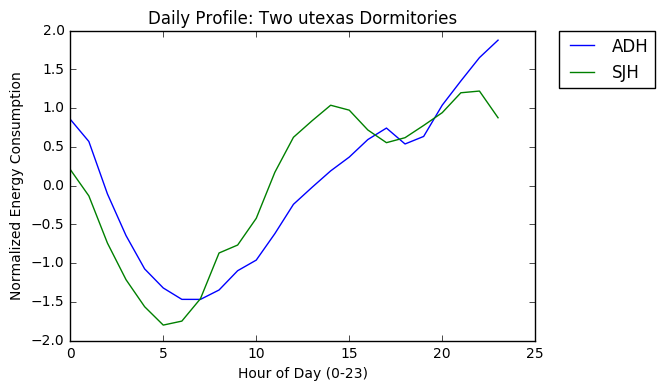

In [53]:
plt.plot(np.arange(24),z_normalize(ADH_avs),label='ADH')
plt.plot(np.arange(24),z_normalize(SJH_avs),label='SJH')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Normalized Energy Consumption')
plt.title('Daily Profile: Two utexas Dormitories')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

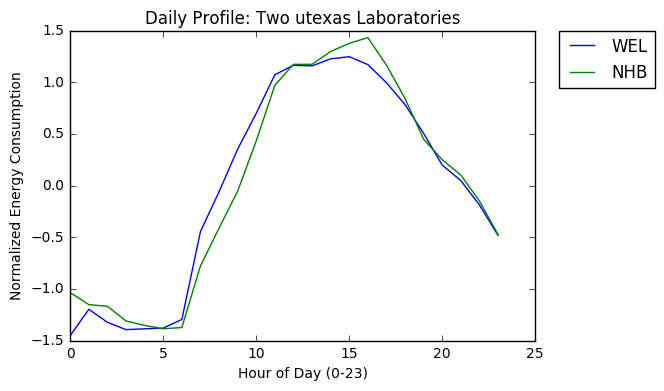

In [54]:
plt.plot(np.arange(24),z_normalize(WEL_avs),label='WEL')
plt.plot(np.arange(24),z_normalize(NHB_avs),label='NHB')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Normalized Energy Consumption')
plt.title('Daily Profile: Two utexas Laboratories')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

As can be seen above, two dormitories have a similar shape and so do two laboratories. 95% confidence bands can be then extrapolated

In [96]:
def bootstrap(data,confidence=95,n_iter=1000):
    bstrap = [[np.mean(utils.resample(l)) for l in azn] for _ in range(n_iter)]
    d = [[occ[i]for occ in bstrap] for i in range(24)]
    ub = [np.percentile(hour,confidence) for hour in d]
    lb = [np.percentile(hour,100-confidence) for hour in d]
    return (lb,ub)
        

The profile, as seen below, has high error, but hopefully an average of various profiles from the same primary space usage will lower the error

[0       122.0
24      124.0
48      122.0
72      121.0
96      119.0
120     116.0
144     118.0
190     121.0
214     119.0
238     124.0
259     118.0
283     117.0
307     121.0
331     126.0
350     135.0
374     178.0
398     185.0
422     186.0
438     188.0
460     193.0
483     198.0
506     179.0
524     196.0
547     207.0
568     223.0
590     204.0
603     191.0
625     199.0
646     185.0
670     212.0
        ...  
4980    148.0
5004    148.0
5069    145.0
5116    143.0
5140    154.0
5164    155.0
5210    156.0
5252    190.0
5276    204.0
5298    203.0
5322    225.0
7067    211.0
7088    156.0
7111    138.0
7135    132.0
7159    137.0
7205    191.0
7229    192.0
7253    186.0
7277    191.0
7301    197.0
7325    193.0
7349    196.0
7456    193.0
7500    184.0
7521    188.0
7545    205.0
7589    139.0
7682    115.0
7706    111.0
Name: 1, dtype: float64, 1       123.0
25      123.0
49      123.0
73      123.0
97      120.0
121     120.0
145     118.0
168     116.0
191     

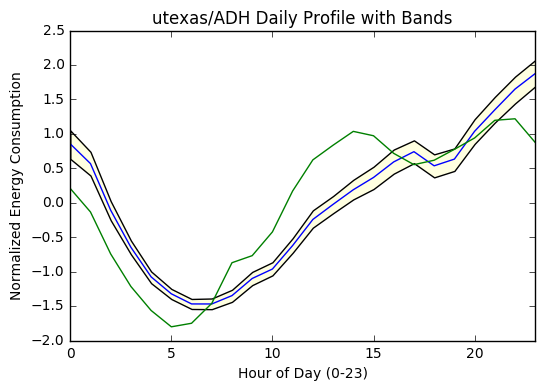

In [108]:
#ADH_profile = daily_profile('ADH',2016)
#SJH_profile = daily_profile('SJH',2016)
lb, ub = bootstrap(ADH_profile,confidence=90)
lb2,ub2 = bootstrap(SJH_profile,confidence=90)
#print(ADH_profile)
#print(SJH_profile)
mu = [np.mean(arr) for arr in z_normalize(ADH_profile,nested_data=True)]
mus = [np.mean(arr) for arr in z_normalize(SJH_profile,nested_data=True)]
plt.plot(np.arange(24),mu)
plt.fill_between(np.arange(24), lb, ub,facecolor='#ffffe0')
#print(lb)
plt.plot(np.arange(24),mus)

#print(lb2)
plt.xlabel('Hour of Day (0-23)')
plt.xlim([0,23])
plt.ylabel('Normalized Energy Consumption')
plt.title('utexas/ADH Daily Profile with Bands')
plt.show()


In [2]:
def plot_hourly(build_df,year,style='-',title='',xlabel = '', ylabel = ''):
    df = build_df.copy()
    df.loc[:,0] = df.apply(lambda x: (x[0]-dt.datetime(year=year,month=1,day=1)).total_seconds()/3600,axis=1)
    plt.plot(df.loc[:,0],df.loc[:,1],style)
    if ylabel == '':
        ylabel = 'Energy Usage (kWH)'
    plt.ylabel(ylabel)
    if xlabel == '':
        xlabel = 'Hours after Jan 1, {} 0:00'.format(year)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()